# Migrating from MapRerankDocumentsChain

[MapRerankDocumentsChain](https://python.langchain.com/v0.2/api_reference/langchain/chains/langchain.chains.combine_documents.map_rerank.MapRerankDocumentsChain.html) implements a strategy for analyzing long texts. The strategy is as follows:

- Split a text into smaller documents;
- Map a process to the set of documents, where the process includes generating a score;
- Rank the results by score and return the maximum.

A common process in this scenario is question-answering using pieces of context from a document. Forcing the model to generate score along with its answer helps to select for answers generated only by relevant context.

An [LangGraph](https://langchain-ai.github.io/langgraph/) implementation allows for the incorporation of [tool calling](/docs/concepts/#functiontool-calling) and other features for this problem. Below we will go through both `MapRerankDocumentsChain` and a corresponding LangGraph implementation on a simple example for illustrative purposes.

## Example

Let's go through an example where we analyze a set of documents. Let's use the following 3 documents:

In [2]:
from langchain_core.documents import Document

documents = [
    Document(page_content="Alice has blue eyes", metadata={"title": "book_chapter_2"}),
    Document(page_content="Bob has brown eyes", metadata={"title": "book_chapter_1"}),
    Document(
        page_content="Charlie has green eyes", metadata={"title": "book_chapter_3"}
    ),
]

### Legacy

<details open>

Below we show an implementation with `MapRerankDocumentsChain`. We define the prompt template for a question-answering task and instantiate a [LLMChain](https://python.langchain.com/v0.2/api_reference/langchain/chains/langchain.chains.llm.LLMChain.html) object for this purpose. We define how documents are formatted into the prompt and ensure consistency among the keys in the various prompts.

In [4]:
from langchain.chains import LLMChain, MapRerankDocumentsChain
from langchain.output_parsers.regex import RegexParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import OpenAI

document_variable_name = "context"
llm = OpenAI()
# The prompt here should take as an input variable the
# `document_variable_name`
# The actual prompt will need to be a lot more complex, this is just
# an example.
prompt_template = (
    "What color are Bob's eyes? "
    "Output both your answer and a score (1-10) of how confident "
    "you are in the format: <Answer>\nScore: <Score>.\n\n"
    "Provide no other commentary.\n\n"
    "Context: {context}"
)
output_parser = RegexParser(
    regex=r"(.*?)\nScore: (.*)",
    output_keys=["answer", "score"],
)
prompt = PromptTemplate(
    template=prompt_template,
    input_variables=["context"],
    output_parser=output_parser,
)
llm_chain = LLMChain(llm=llm, prompt=prompt)
chain = MapRerankDocumentsChain(
    llm_chain=llm_chain,
    document_variable_name=document_variable_name,
    rank_key="score",
    answer_key="answer",
)

In [9]:
response = chain.invoke(documents)
response["output_text"]

/langchain/libs/langchain/langchain/chains/llm.py:369: UserWarning: The apply_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


'Brown'

Inspecting the [LangSmith trace](https://smith.langchain.com/public/7a071bd1-0283-4b90-898c-6e4a2b5a0593/r) for the above run, we can see three LLM calls-- one for each document-- and that the scoring mechanism mitigated against hallucinations.

</details>

### LangGraph

<details open>

Below we show a LangGraph implementation of this process. Note that our template is simplified, as we delegate the formatting instructions to the chat model's tool-calling features via the [.with_structured_output](/docs/how_to/structured_output/) method.

Here we follow a basic [map-reduce](https://langchain-ai.github.io/langgraph/how-tos/map-reduce/) workflow to execute the LLM calls in parallel.

We will need to install `langgraph`:

In [ ]:
pip install -qU langgraph

In [6]:
import operator
from typing import Annotated, List, TypedDict

from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph


class AnswerWithScore(TypedDict):
    answer: str
    score: Annotated[int, ..., "Score from 1-10."]


llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

prompt_template = "What color are Bob's eyes?\n\n" "Context: {context}"
prompt = ChatPromptTemplate.from_template(prompt_template)

# The below chain formats context from a document into a prompt, then
# generates a response structured according to the AnswerWithScore schema.
map_chain = prompt | llm.with_structured_output(AnswerWithScore)

# Below we define the components that will make up the graph


# This will be the overall state of the graph.
# It will contain the input document contents, corresponding
# answers with scores, and a final answer.
class State(TypedDict):
    contents: List[str]
    answers_with_scores: Annotated[list, operator.add]
    answer: str


# This will be the state of the node that we will "map" all
# documents to in order to generate answers with scores
class MapState(TypedDict):
    content: str


# Here we define the logic to map out over the documents
# We will use this an edge in the graph
def map_analyses(state: State):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [
        Send("generate_analysis", {"content": content}) for content in state["contents"]
    ]


# Here we generate an answer with score, given a document
async def generate_analysis(state: MapState):
    response = await map_chain.ainvoke(state["content"])
    return {"answers_with_scores": [response]}


# Here we will select the top answer
def pick_top_ranked(state: State):
    ranked_answers = sorted(
        state["answers_with_scores"], key=lambda x: -int(x["score"])
    )
    return {"answer": ranked_answers[0]}


# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(State)
graph.add_node("generate_analysis", generate_analysis)
graph.add_node("pick_top_ranked", pick_top_ranked)
graph.add_conditional_edges(START, map_analyses, ["generate_analysis"])
graph.add_edge("generate_analysis", "pick_top_ranked")
graph.add_edge("pick_top_ranked", END)
app = graph.compile()

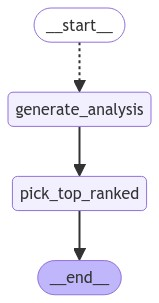

In [7]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [8]:
result = await app.ainvoke({"contents": [doc.page_content for doc in documents]})
result["answer"]

{'answer': 'Bob has brown eyes.', 'score': 10}

Inspecting the [LangSmith trace](https://smith.langchain.com/public/b64bf9aa-7558-4c1b-be5c-ba8924069039/r) for the above run, we can see three LLM calls as before. Using the model's tool-calling features have also enabled us to remove the parsing step.

</details>

## Next steps

See these [how-to guides](/docs/how_to/#qa-with-rag) for more on question-answering tasks with RAG.

Check out the [LangGraph documentation](https://langchain-ai.github.io/langgraph/) for detail on building with LangGraph, including [this guide](https://langchain-ai.github.io/langgraph/how-tos/map-reduce/) on the details of map-reduce in LangGraph.